<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin





In [32]:
def drop_non_numeric_columns(df):
    """Drops columns from a DataFrame that do not contain numeric values.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with non-numeric columns removed.
    """
    numeric_df = df.select_dtypes(include=np.number)
    return numeric_df

In [33]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        self.to_drop_ = set()
        for col1 in upper.columns:
            for col2 in upper.index:
                if col1 == col2:
                    continue
                if upper.loc[col2, col1] > self.threshold:
                    self.to_drop_.add(col2)  # Arbitrary: could also keep based on y

        return self

    def transform(self, X):
        df = pd.DataFrame(X)
        return df.drop(columns=self.to_drop_, errors="ignore").values

In [35]:
# Load data
train_df = pd.read_csv("Landrum_All_training_mordred.csv")
test_df = pd.read_csv("Landrum_All_training_mordred.csv")

train_df=drop_non_numeric_columns(train_df)
test_df=drop_non_numeric_columns(test_df)

# Separate features and labels
X_train = train_df.drop(columns=["active", "Unnamed: 0"], errors="ignore")
y_train = train_df["active"]
X_test = test_df.drop(columns=["active", "Unnamed: 0"], errors="ignore")
y_test = test_df["active"]

# Align and drop missing
shared_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[shared_cols].dropna(axis=1)
X_test = X_test[X_train.columns].dropna(axis=1)





<ipython-input-35-2c9a2d9727e9>:2: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,56,57,58,59,60,61,62,63,64,143,144,152,153,155,156,157,158,159,160,161,170,171,179,180,188,189,197,198,206,207,215,216,224,225,233,234,236,237,238,239,240,241,242,243,244,263,264,265,266,267,268,269,270,271,344,345,346,347,348,349,350,359,360,368,369,371,372,373,374,375,376,377,386,387,395,396,404,405,413,414,422,423,431,432,440,441,449,450,452,453,454,455,456,457,465,466,473,474,476,477,478,479,480,481,489,490,497,498,505,506,513,514,521,522,529,530,537,538,545,546,548,549,550,551,552,553,561,562,569,570,572,573,574,575,576,577,585,586,593,594,601,602,609,610,617,618,625,626,633,634,641,642,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,72

In [45]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif)),  # You can change score_func if needed
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Define parameter grid
param_grid = {
    'select__k': [5, 10, 20],               # Number of features to select
    'logreg__C': [1, 10, 100],          # Regularization strength
    'logreg__penalty': ['l1', 'l2']                # L1 (sparse) vs. L2 (ridge)
}

In [46]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run grid search
random_search = RandomizedSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

# Output best model and parameters
print("Best random parameters:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

# Use the best model to predict
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)



Best random parameters: {'select__k': 20, 'logreg__penalty': 'l2', 'logreg__C': 100}
Best cross-validation accuracy: 0.7233064474773448


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 12 509 510 511 512 513 514 518 522 528 530 535 547 548 549 551 552 553
 555 560 563 564 565 566 567 568 569 570 571 572 576 577 579 580 581 582
 584 585 586 587 588 589 590 591 592 593 597 601 607 609 614 626 627 628
 630 631 632 634 639 642 643 644 645 646 647 648 649 650 651 655 656 658
 659 660 661 663 664 665 666 740 750 803 804 805 813 814 815 816 817 818
 820 821 824 825 826 827 828 829 830 832 833 836 837 838 839 840 841 842
 851 852 853 861 862 863 864 865 866 868 869 870 879 880 881 890 891 892
 893 897 901 902 903 904 908 912 913 914 923 924 925 931] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


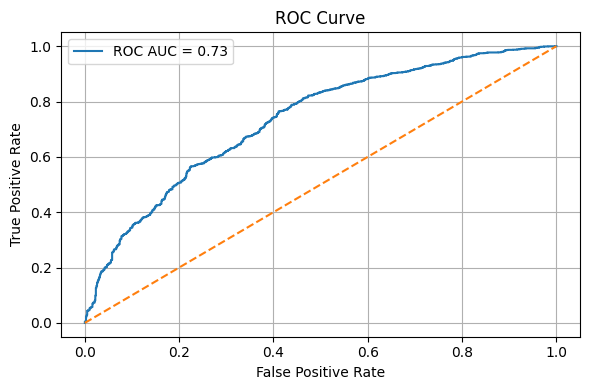

In [47]:
# Evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
